# Scholarly Research (STORM)

[STORM](https://arxiv.org/abs/2402.14207) is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.

STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density.

The control flow looks like the diagram below.

STORM has a few main stages:

1. Generate initial outline + Survey related subjects
2. Identify distinct perspectives
3. "Interview subject matter experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article


The expert interviews stage occurs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

There are a couple hyperparameters you can set to restrict the (potentially) infinite research breadth:

N: Number of perspectives to survey / use (Steps 2->3)
M: Max number of conversation turns in step (Step 3)


## Setup

First, let's install the required packages and set our API keys

In [ ]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_fireworks langgraph wikipedia duckduckgo-search tavily-python

In [ ]:
# Uncomment if you want to draw the pretty graph diagrams.
# If you are on MacOS, you will need to run brew install graphviz before installing and update some environment flags
# ! brew install graphviz
# !CFLAGS="-I $(brew --prefix graphviz)/include" LDFLAGS="-L $(brew --prefix graphviz)/lib" pip install -U pygraphviz

In [ ]:
import getpass
import os
from openai import OpenAI
from langchain_openai import ChatOpenAI


def _set_env(var: str):
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var + ":")

os.environ["OPENALEX_EMAIL"] = "josepharcila@gmail.com"

# OpenAI
api_key = "b21428322f364595910f4d001b28f2608ef1cc7745d846a2ad89aed1e6d244ff"
base_url = "https://llmapi.ops.avilen.co.jp/v1/linkers-lfm/"

# Initialize client
client = OpenAI(base_url=base_url, api_key=api_key)

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>   

### Select LLMs

We will have a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [ ]:
from langchain_openai import ChatOpenAI

# fast_llm = ChatOpenAI(openai_api_base=base_url, openai_api_key=api_key, model="openai.gpt-4o")
# Uncomment for a Fireworks model
# fast_llm = ChatFireworks(model="accounts/fireworks/models/firefunction-v1", max_tokens=32_000)
long_context_llm = ChatOpenAI(openai_api_base=base_url, openai_api_key=api_key, model="openai.o1-2024-12-17")

## Generate Initial Outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [ ]:
from typing import List, Optional

from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "あなたはWikipediaの執筆者です。ユーザーが提供したトピックについてのWikipediaページの概要を作成してください。包括的かつ具体的に書いてください。",
        ),
        ("user", "{topic}"),
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title="小節のタイトル")
    description: str = Field(..., title="小節の内容")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="節のタイトル")
    description: str = Field(..., title="節の内容")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Wikipediaページの各小節のタイトルと説明",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Wikipediaページのタイトル")
    sections: List[Section] = Field(
        default_factory=list,
        title="Wikipediaページの各節のタイトルと説明",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [ ]:
# example_topic = "熱・風以外の方法で髪の毛を乾かす技術のトレンドを教えて"
# example_topic = "アミンを用いた固体状のCO2吸着剤のトレンドを教えて"
example_topic = "エクソソームの研究のトレンドを教えて"
# example_topic = "安全に関する行動変容手法のトレンドを教えて"
# example_topic = "加熱調理器における料理品質・体験・機能に関する開発のトレンドを教えて"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# エクソソーム研究のトレンド

## 概要

エクソソームとは、細胞が分泌する直径30～150nm程度の小胞であり、タンパク質やリポイド、核酸など多様な生体分子を含む。細胞間情報伝達に重要な役割を果たすと考えられ、がん研究や再生医療など幅広い分野で注目されている。本節ではエクソソームの基本的な特徴と、研究分野全体のトレンドを概観する。

### エクソソームの機能と特性

エクソソームはシグナル伝達、細胞間コミュニケーション、免疫応答などにおいて重要な働きを持つ。また、エクソソームの膜タンパク質や内部に含まれる核酸（microRNA, mRNAなど）の解析により、疾患のバイオマーカーとして期待されている。

## 研究の歴史

エクソソームに関する研究は1980年代に始まり、当初は細胞の老廃物排出経路として認知されていたが、その後細胞間情報伝達に大きく貢献するとの知見が蓄積し注目が高まった。1990年代以降、先端的な解析技術の発展とともに研究が加速し、多様な疾患や生理機能との関連が明らかとなってきた。

## 解析技術の進歩

エクソソーム研究を支える解析技術は年々進歩しており、分離・精製法や高感度なオミクス解析などがキーポイントとなっている。

### 分離・精製技術の高度化

超遠心法やサイズ排除クロマトグラフィー、イムノアフィニティ法など、より高純度かつ高収量でエクソソームを取得するための方法が開発・改良されている。また微小流路などのマイクロ流体デバイスを用いた分離法も提案されている。

### 多角的オミクス解析

プロテオーム解析・トランスクリプトーム解析・メタボローム解析などの包括的解析が可能となり、エクソソームが含む生体分子の全体像を把握しやすくなった。特に次世代シーケンサー（NGS）の普及により、エクソソーム中のmiRNAやlncRNAなどの非コードRNAの研究が急速に進展している。

## 応用研究のトレンド

エクソソームを利用した診断・治療技術の開発が活発化しており、がんや神経変性疾患などへの応用が注目されている。

### バイオマーカー開発

血中や体液中に含まれるエクソソームから、疾患特異的なmiRNAやタンパク質を検出することで、早期診断につなげる試みが進んでいる。非侵襲的な検査手法として期待が高まっている。

### ドラッグデリバ

## Expand Topics

While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [ ]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """以下のトピックについてWikipediaページを執筆しています。関連する主題のWikipediaページを特定し、推奨してください。このトピックに一般的に関連する興味深い側面についての洞察を提供する例や、類似トピックのWikipediaページに含まれる典型的な内容と構造を理解するのに役立つ例を探しています。
できるだけ多くの関連主題とURLを列挙してください。
対象トピック: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="背景調査のための関連主題の包括的なリスト",
    )


expand_chain = gen_related_topics_prompt | long_context_llm.with_structured_output(
    RelatedSubjects
)

In [ ]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['エクソソーム: https://ja.wikipedia.org/wiki/エクソソーム', '細胞外小胞: https://ja.wikipedia.org/wiki/細胞外小胞', 'マイクロベシクル: https://ja.wikipedia.org/wiki/マイクロベシクル', '液性生検: https://ja.wikipedia.org/wiki/液性生検', 'バイオマーカー: https://ja.wikipedia.org/wiki/バイオマーカー', 'ドラッグデリバリーシステム: https://ja.wikipedia.org/wiki/ドラッグデリバリーシステム', '遺伝子治療: https://ja.wikipedia.org/wiki/遺伝子治療', 'MicroRNA: https://ja.wikipedia.org/wiki/MicroRNA', '細胞シグナリング: https://ja.wikipedia.org/wiki/細胞シグナリング', '腫瘍微小環境（英語）: https://en.wikipedia.org/wiki/Tumor_microenvironment', '免疫療法: https://ja.wikipedia.org/wiki/免疫療法', 'ナノメディシン: https://ja.wikipedia.org/wiki/ナノメディシン'])

## Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as "subject matter experts" with distinct
backgrounds and affiliations. These will help distribute the search process to encourage a more well-rounded final report.

In [ ]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="編集者の主な所属",
    )
    name: str = Field(
        description="編集者の名前", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="トピックに関連する編集者の役割",
    )
    description: str = Field(
        description="編集者の焦点、関心事、動機の説明",
    )

    @property
    def persona(self) -> str:
        return f"名前: {self.name}\n役割: {self.role}\n所属: {self.affiliation}\n説明: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="編集者とその役割、所属の包括的なリスト",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """トピックについて包括的な記事を作成するために協力して作業する、多様で個性的なWikipedia編集者グループを選定する必要があります。各編集者は、このトピックに関連する異なる視点、役割、所属を代表します。\

    着想を得るために、関連トピックの他のWikipediaページを参考にすることができます。各編集者について、何に焦点を当てるかの説明を追加してください。

    着想を得るための関連トピックのWikiページの概要：

    {examples}""",
        ),
        ("user", "対象トピック: {topic}"),
    ]
)

gen_perspectives_chain = (
    gen_perspectives_prompt
    | ChatOpenAI(
        openai_api_base=base_url,
        openai_api_key=api_key,
        model="openai.gpt-3.5-turbo"
    ).with_structured_output(
        Perspectives,
        method="function_calling"
    )
)

In [ ]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables import chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\n概要: {doc.page_content}\n\n関連\n{related}"[
        :max_length
        ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [ ]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [ ]:
perspectives.dict()

<ipython-input-12-b975437d5130>:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  perspectives.dict()


{'editors': [{'affiliation': 'Research Institute A',
   'name': 'Alice123',
   'role': 'Research Scientist',
   'description': 'Alice is a research scientist specializing in the study of exosomes. She focuses on the latest research trends, experimental methodologies, and breakthroughs in the field of exosome research.'},
  {'affiliation': 'University B',
   'name': 'Bob456',
   'role': 'Academic Researcher',
   'description': 'Bob is an academic researcher with a keen interest in exosome research trends. He follows developments in exosome-based diagnostics, therapeutics, and potential applications in various fields.'},
  {'affiliation': 'Biotech Company C',
   'name': 'Chris789',
   'role': 'Biotech Industry Expert',
   'description': 'Chris is a biotech industry expert closely monitoring the commercial aspects of exosome research, including market trends, investment opportunities, and the development of exosome-based products.'}]}

## Expert Dialog

Now the true fun begins, each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.


### Interview State

The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [ ]:
from typing import Annotated

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

#### Dialog Roles

The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain), who uses a search engine to answer the questions as accurately as possible.

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.prompts import MessagesPlaceholder

gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """あなたは経験豊富なWikipedia編集者で、特定のページを編集したいと考えています。
Wikipedia編集者としての立場に加えて、トピックを研究する際の特定の焦点があります。
現在、専門家と情報を得るためにチャットをしています。有用な情報を得るために、良い質問をしてください。
質問がなくなったら、「ご協力ありがとうございました！」と言って会話を終了してください。
質問は一度に一つずつ行い、以前に尋ねた質問は繰り返さないでください。
質問は執筆したいトピックに関連したものにしてください。
包括的で好奇心を持って、専門家からできるだけ多くのユニークな洞察を得るようにしてください。\
あなたの特定の視点を忠実に守ってください：
{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | long_context_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [ ]:
messages = [
    HumanMessage(f"では、{example_topic}について記事を書いているとおっしゃっていましたか？")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

'はい、そうです。エクソソーム研究のトレンドについての記事を執筆しています。  \nそこで一つ目の質問なのですが、過去1年間におけるエクソソーム研究の中で、最も画期的だと思われる発見や進展は何でしょうか？  '

#### Answer questions

The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [ ]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="ユーザーの質問に答えるためのOpenAlex検索エンジンクエリの包括的なリスト",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "あなたは役立つ学術研究アシスタントです。ユーザーの質問に答えるためにOpenAlex APIの検索エンジンに問い合わせてください。",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    openai_api_base=base_url,
    openai_api_key=api_key,
    model="openai.o1-2024-12-17"
).with_structured_output(Queries, include_raw=True)

In [ ]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['search=exosome+breakthroughs+OR+advancements&filter=from_publication_date:2022-10-01,to_publication_date:2023-10-06&sort=cited_by_count:desc']

In [ ]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="引用付きのユーザーの質問に対する包括的な回答",
    )
    cited_urls: List[str] = Field(
        description="回答で引用したURLのリスト",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\n参考文献：\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """あなたは情報を効果的に使用できる専門家です。あなたの知るトピックについてWikipediaページを書きたいと考えているWikipedia編集者とチャットしています。関連情報を収集しており、これからその情報を使用して回答を作成します。
できるだけ情報量の多い回答を心がけ、すべての文章が収集した情報によって裏付けられていることを確認してください。
各回答は信頼できる情報源からの引用で裏付けられている必要があり、脚注として形式を整え、回答の後にURLを再掲してください。""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | long_context_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [ ]:
import os
import requests
from typing import List, Dict
from langchain_core.tools import tool

class OpenAlexSearchAPIWrapper:
    """Wrapper for OpenAlex API."""
    def __init__(self, openalex_email: str = None):
        self.openalex_email = openalex_email or os.getenv("OPENALEX_EMAIL")

    def _ddgs_text(self, query: str) -> List[Dict]:
        """Method named to match DuckDuckGo wrapper pattern."""
        headers = {'User-Agent': f'mailto:{self.openalex_email}'}
        url = "https://api.openalex.org/works"
        params = {
            "search": str(query),
            "per-page": 10,
            "page": 1,
            "sort": "relevance_score:desc",
            "select": "id,display_name,publication_year,abstract_inverted_index,doi,primary_location"
        }

        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            data = response.json()
            results = []
            for work in data.get('results', []):
                if not work:
                    continue

                abstract = ""
                if abstract_index := work.get('abstract_inverted_index'):
                    word_positions = {pos: word for word, positions in abstract_index.items() for pos in positions}
                    abstract = " ".join(word_positions[i] for i in sorted(word_positions.keys()))

                url = None
                if work.get('doi'):
                    url = f"https://doi.org/{work['doi'].replace('https://doi.org/', '')}"
                elif work.get('primary_location', {}).get('doi'):
                    url = f"https://doi.org/{work['primary_location']['doi']}"
                elif work.get('id'):
                    work_id = work['id'].replace('https://openalex.org/', '')
                    url = f"https://openalex.org/{work_id}"

                if url:
                    results.append({
                        "content": f"Title: {work.get('display_name', '')}\nAbstract: {abstract}",
                        "url": url
                    })
            return results
        return []

# Initialize the search engine
search_engine = OpenAlexSearchAPIWrapper()

@tool
async def search_engine(query: str):
    """Search engine for scholarly works."""
    results = OpenAlexSearchAPIWrapper()._ddgs_text(query)
    return results

In [ ]:
# # For testing in Jupyter/IPython notebook
# import nest_asyncio
# from langchain_core.callbacks import BaseCallbackManager
# from langchain_core.runnables import RunnableConfig  # Changed this import
# import asyncio
# from typing import Optional

# nest_asyncio.apply()

# async def test_search():
#     query = "Long context LLM patents"

#     # Create a config dictionary with None callback manager
#     config: Optional[RunnableConfig] = None

#     # Pass config to _arun
#     results = await search_engine._arun(query, config=config)

#     # Print results - updated to match the search_engine return structure
#     for idx, result in enumerate(results, 1):
#         print(f"\nResult {idx}:")
#         print(f"Content: {result['content']}")  # Changed from 'body' to 'content'
#         print(f"URL: {result['url']}")  # Changed from 'href' to 'url'

# # Run in notebook
# await test_search()

In [ ]:
import json

from langchain_core.runnables import RunnableConfig


async def gen_answer(
    state: InterviewState,
    config: Optional[RunnableConfig] = None,
    name: str = "Subject_Matter_Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    search_message = HumanMessage(content=dumped)
    swapped_state["messages"].extend([queries["raw"], search_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [ ]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

'今後5年から10年にかけて、エクソソーム研究はがん治療・診断だけでなく、再生医療や希少疾患に対する革新的治療法の新規開発など、より幅広い応用へと展開していくと考えられています[1]。以下のような分野の発展が特に大きな注目を集めると予想されます：\n\n1. 標準化された手法の確立：\nエクソソームを分離・純化し、機能や由来細胞を正確に特定する標準化されたプロトコルの確立が進むと期待されています。現在、エクソソームの回収方法には超遠心法、サイズ排除クロマトグラフィー、免疫親和法など複数のアプローチがあり、それぞれにメリットとデメリットがあります。これらの方法を比較検討し、臨床応用で通用するよう十分に再現性を検証した手法が広まることにより、研究成果の再現性向上と臨床利用の促進が見込まれます[2][3]。\n\n2. バイオマーカーとしての活用：\n液体生検の一環として、血液や体液中のエクソソームを解析し、がんなどの早期診断へ活用する研究がより盛んになるでしょう。エクソソームにはマイクロRNAやタンパク質、DNA断片など多種多様な情報が含まれており、診断精度の向上や疾患特異的マーカーの同定につながると期待されています[4]。\n\n3. 遺伝子治療やドラッグデリバリーへの応用：\nエクソソームは細胞由来の小胞であるため、生体適合性が高く免疫原性が低いことなどの特徴をもちます。新薬や遺伝子治療を送達するベクターとしての利用は今後さらに拡大し、がん治療、神経変性疾患、自己免疫疾患などの治療開発のプラットフォームとなる可能性があります[5][6]。\n\n4. 工学的改変による機能強化：\n特定の細胞や組織を標的としたエクソソームの送達効率向上のため、エクソソームの膜タンパク質や内部 cargo を遺伝子工学的に改変する研究が加速していくと考えられます。例えば、特定の受容体への特異的結合を高めるタンパク質をエクソソーム表面に導入する技術などが既に報告されており、今後さらに高度化が進むでしょう[7]。\n\n5. 生産プラットフォームの拡充と品質管理：\nエクソソームを大規模かつ高品質に生産する技術や、最終製剤の品質管理技術の確立も重要な課題です。培養条件の最適化や工場レベルでの生産技術を確立することで製品化に向けた道筋が整備され、より多くの臨床アプリケーションへ展開されると期

#### Construct the Interview Graph


Now that we've defined the editor and domain expert, we can compose them in a graph.

In [ ]:
max_num_turns = 5
from langgraph.pregel import RetryPolicy


def route_messages(state: InterviewState, name: str = "Subject_Matter_Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("ご協力ありがとうございました！"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question, retry=RetryPolicy(max_attempts=5))
builder.add_node("answer_question", gen_answer, retry=RetryPolicy(max_attempts=5))
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.add_edge(START, "ask_question")
interview_graph = builder.compile(checkpointer=False).with_config(
    run_name="Conduct Interviews"
)

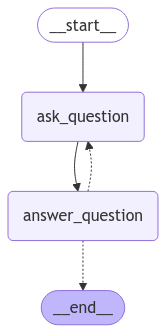

In [ ]:
from IPython.display import Image, display

try:
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"では、{example_topic}について記事を書いているとおっしゃっていましたか？",
            name="Subject_Matter_Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
final_step = step

<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


ask_question
--  [AIMessage(content='はい、エクソソームの最新研究動向をまとめたいと考えています。そこでまず、現在注目されているエクソソームの分離・解析技術にはどのような新しいものがありますか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 894, 'prompt_tokens': 291, 'total_tokens': 1185, 'completion_tokens_details': {'accepted_prediction_tokens


<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


answer_question
--  [AIMessage(content='近年、エクソソーム分離・解析技術としては従来から使われてきた超遠心法や沈降試薬法などに加えて、微小流体デバイスを用いたラベルフリーの分離方法やアコースティック（音響）技術を組み合わせた手法など、より高効率・高純度なアプローチが注目されています[8,10]。特に微小流体技術では、巨大な血球やタンパク質との分離をリアルタイムかつ少量サンプルで行えるため、迅速・省サンプルの分離が可能になります[10]。アコースティック技術を応用した手法は、ラベルを使用せず試料をほぼそのまま分離できることに加え、生体由来のエクソソームを構造損失なく得やすいという利点が報告されて


<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


ask_question
--  [AIMessage(content='エクソソームの臨床応用に向けた研究として、特に注目すべき分野や、課題となっているポイントにはどのようなものがありますか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 696, 'prompt_tokens': 1052, 'total_tokens': 1748, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_toke


<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


answer_question
--  [AIMessage(content='エクソソームの臨床応用に向けた研究は、多くの領域で進展が期待されています。特にがん診療の分野では、腫瘍由来のエクソソームがリキッドバイオプシーにおける有望な分子マーカーとして注目されており、早期診断や治療効果のモニタリング、再発リスクの評価に向けて利用が検討されています[1][2]。がんの診断やサブタイプの特定などにおいて、従来の組織生検では困難だった腫瘍の空間的・時間的な不均一性を捉えやすい点が大きな利点です[2]。\n\n一方、課題としては以下のようなポイントが挙げられます：\n\n1. 標準化と再現性の確立\n   エクソソームの分離・精製法が多数


<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


ask_question
--  [AIMessage(content='再生医療の観点から、エクソソームを利用した組織修復や細胞機能促進への応用はどのように進展しており、特にどのような技術的・安全性面の課題が残っているのでしょうか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 717, 'prompt_tokens': 2002, 'total_tokens': 2719, 'completion_tokens_details': {'accepted_prediction_tok


<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


answer_question
--  [AIMessage(content='再生医療の文脈においてエクソソームは、細胞が分泌する微小な小胞として、細胞間シグナル伝達や組織修復プロセスへ積極的に関与する点が期待されています。特に間葉系幹細胞（Mesenchymal Stem Cells: MSCs）由来のエクソソームが、炎症抑制や組織再生を促すさまざまなタンパク質・RNAを内包していることから、多領域にわたって研究が進められています[1][3]。\\n\\n■エクソソームを用いた組織修復・細胞機能促進の主な応用例\\n1）創傷治癒・軟骨再生：MSCs由来エクソソームを用いることで、創部の炎症を制御しながら血管新生や線維芽細胞の増殖


<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


ask_question
--  [AIMessage(content='エクソソームが標的細胞へ取り込まれるメカニズムや、それによって細胞間コミュニケーションがどのように調整されるのかという点について、新たに注目されている知見やモデルはありますか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 648, 'prompt_tokens': 3413, 'total_tokens': 4061, 'completion_tokens_details': {'accepted_predic


<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))


answer_question
--  [AIMessage(content='エクソソームが標的細胞に取り込まれるメカニズムは多様で、主にリガンド–受容体相互作用やエンドサイトーシス、膜融合など複数の経路が関与すると考えられています[1][2]。エクソソーム表面にはコレステロールやホスファチジルセリン、テトラスパニン（CD9, CD63, CD81 など）といった特徴的な分子が多数存在し、ターゲット細胞の膜上にある特定の受容体や糖タンパク質と結合することで結合から細胞内取り込みが起こると報告されています[1][3]。また、膜融合型の取り込みではエクソソームの脂質二重膜が標的細胞膜と直接融合し、中の内容物（タンパク質、mRNA、mi


In [ ]:
final_state = next(iter(final_step.values()))

## Refine Outline

At this point in STORM, we've conducted a large amount of research from different perspectives. It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [ ]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """あなたはWikipedia編集者です。専門家や検索エンジンから情報を収集しました。これから、Wikipediaページの概要を改善します。
概要が包括的かつ具体的であることを確認してください。
執筆するトピック: {topic}
以前の概要:
{old_outline}""",
        ),
        (
            "user",
            "専門家との会話に基づいて概要を改善してください：\n\n会話内容：\n\n{conversations}\n\n改善されたWikipediaの概要を作成してください：",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [ ]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [ ]:
print(refined_outline.as_str)

# エクソソーム研究のトレンド

## 概要

エクソソームは細胞が放出する直径30～150nm程度の膜小胞で、タンパク質・脂質・核酸など多様な生体分子を内包する。かつては不要物質の排出経路とみなされていたが、細胞間情報伝達に重要な役割を担うことが判明し、多くの研究が急速に進展した。近年ではがん、再生医療、神経変性疾患など広範な分野で注目されており、バイオマーカーやドラッグデリバリーシステム（DDS）としての応用研究も活発化している。

### エクソソームの機能と特性

エクソソームは細胞間コミュニケーションを媒介し、免疫制御や組織リモデリングなど多段階の生理・病理プロセスに関与する。表面にはテトラスパニン（CD9・CD63・CD81など）やホスファチジルセリン、コレステロールなど特徴的な分子を多く含み、これらの分子が受容体との相互作用により標的細胞へ特異的に結合・取り込みを促す。また内部にはmRNAやmiRNAなどの核酸も含まれており、遺伝子発現制御に寄与する。

## エクソソームの取り込みと細胞間コミュニケーション

エクソソームが標的細胞に取り込まれるメカニズムは、リガンド–受容体相互作用やエンドサイトーシス、膜融合など複数の経路によって進行すると考えられている[1][2]。エクソソームの表面に存在するテトラスパニンやリガンド分子がターゲット細胞上の受容体や糖タンパク質と結合することによって結合や取り込みが促進されるほか、膜融合によってエクソソーム内部の核酸やタンパク質が直接細胞質に放出され、細胞機能や遺伝子発現を変化させる。エクソソームが免疫応答の調整やがん転移の促進など、多様な生理機能の制御に関わることが報告されており、細胞間ネットワークの調整役としての役割が注目されている[2][3][4]。

### がん領域における新たなモデル

がん転移では、エクソソームが転移先の微小環境を“プログラミング”することで、腫瘍細胞の生存や定着を助けるメカニズムが示唆されている[4]。この過程でエクソソームは免疫細胞や間質細胞へ情報を伝えるメッセンジャーとして機能し、がんの増殖や転移能、薬剤抵抗性を高めるプロセスに寄与するとされる。

## 研究の歴史

エクソソーム研究は1980年代に細胞外小胞としての存在が報告されて以来、細胞老廃物の排出機構と考えられていたが、

## Generate Article

Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual llm. Then we will prompt the long-form LLM to refine the finished article (since each section may use an inconsistent voice).

#### Create Retriever

The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

First, create the retriever:

In [ ]:
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    openai_api_base=base_url,
    openai_api_key=api_key,
    model="openai.text-embedding-3-large")
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = InMemoryVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=3)

In [ ]:
retriever.invoke("熱や風を使わずに髪を乾かすための革新的な新技術として、今特に注目されているアイテムや方法にはどのようなものがありますか？")

[Document(id='e315820c-6d91-47ee-9c57-79e44115e33d', metadata={'source': 'https://doi.org/10.3390/bios11120518'}, page_content='Title: Exosomes as Powerful Engines in Cancer: Isolation, Characterization and Detection Techniques\nAbstract: Exosomes, powerful extracellular nanovesicles released from almost all types of living cells, are considered the communication engines (messengers) that control and reprogram physiological pathways inside target cells within a community or between different communities. The cell-like structure of these extracellular vesicles provides a protective environment for their proteins and DNA/RNA cargos, which serve as biomarkers for many malicious diseases, including infectious diseases and cancers. Cancer-derived exosomes control cancer metastasis, prognosis, and development. In addition to the unique structure of exosomes, their nanometer size and tendency of interacting with cells makes them a viable novel drug delivery solution. In recent years, numerous

#### Generate Sections

Now you can generate the sections using the indexed docs.

In [ ]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="小節のタイトル")
    content: str = Field(
        ...,
        title="小節の完全な内容。関連する箇所には [#] の形式で出典を含めてください。",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="節のタイトル")
    content: str = Field(..., title="節の完全な内容")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Wikipediaページの各小節のタイトルと説明",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "あなたは熟練したWikipedia編集者です。以下の概要から割り当てられたWikiSectionを完成させてください：\n\n"
            "{outline}\n\n以下の参考文献を用いて出典を記載してください：\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "{section}セクションのWikiSectionを完全に執筆してください。"),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [ ]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## エクソソームの取り込みと細胞間コミュニケーション

エクソソームが標的細胞に取り込まれるメカニズムは、リガンド–受容体相互作用やエンドサイトーシス、膜融合など複数の経路によって進行すると考えられている[1][2]。エクソソームの表面に存在するテトラスパニンやリガンド分子は、標的細胞上の受容体や糖タンパク質と結合することで結合や取り込みを促進する一方、膜融合によって内部の核酸やタンパク質を直接細胞質に放出し、細胞機能や遺伝子発現を変化させる。近年の研究では、エクソソームが免疫応答やがん転移の促進といった多様な生理機能の制御に関わることが報告され、細胞間コミュニケーションの重要な調整役として注目されている[2][3][4]。

### 取り込みのメカニズム

エクソソームは、その表面に存在する膜タンパク質やリガンド分子を介して標的細胞に結合し、エンドサイトーシスや膜融合などの機構で細胞内へと取り込まれる[1][2]。取り込まれたエクソソームが輸送する核酸やタンパク質は、細胞質やエンドソーム内で機能を発揮し、受容細胞のシグナル伝達や遺伝子発現を変化させる。

### 細胞間コミュニケーションにおける役割

エクソソームはタンパク質・mRNA・miRNAなど多様な分子を運搬し、細胞間ネットワークの調整に関与する[2][3][4]。特にがん細胞由来のエクソソームは、腫瘍周囲の微小環境のプログラミングや免疫細胞への情報伝達を通じて、がんの増殖・転移を促進することが示唆されている[1][3]。また、免疫応答の調節や神経変性疾患など幅広い生理・病理現象に寄与する可能性も指摘されており、細胞間コミュニケーションを解明する上で重要な焦点となっている。[0] https://doi.org/10.3390/bios11120518
 [1] https://doi.org/10.3389/fnmol.2023.1227655
 [2] https://doi.org/10.3390/pharmaceutics10040218
 [3] https://doi.org/10.20944/preprints201810.0507.v1


#### Generate final article

Now we can rewrite the draft to appropriately group all the citations and maintain a consistent voice.

In [ ]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """あなたは熟練したWikipedia編集者です。以下のセクション原稿を使用して{topic}に関する完全なWiki記事を執筆してください：\n\n
            {draft}\n\nWikipediaの形式ガイドラインに厳密に従ってください。""",
        ),
        (
            "user",
            """マークダウン形式で完全なWiki記事を執筆してください。脚注は「[1]」のような形式で表記し、フッターで重複を避けてください。フッターにはURLを含めてください。""",
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [ ]:
final_text = writer.invoke({"topic": example_topic, "draft": section.as_str})
print(final_text)

# エクソソーム

**エクソソーム**（英: exosome）とは、真核細胞が分泌する直径30～150 nm程度の小胞であり、細胞間コミュニケーションにおいて重要な役割を果たすと考えられている。エクソソームの内部にはタンパク質、リピッド、mRNA、miRNAなど多様な分子が含まれ、これらを細胞外へと運搬することで、ターゲット細胞に対して遺伝子発現やシグナル伝達の調節を行う。近年はがんの転移促進や免疫応答の制御などへの寄与が示唆され、バイオマーカーや治療ツールとしての利用が期待されている。

## 生合成と放出

エクソソームは、まず細胞内のエンドソームが多胞体（multivesicular body, MVB）へと成熟し、その内部に形成された小胞が細胞膜と融合して細胞外へ放出されることで生成される。MVBがリソソームと融合した場合には内容物が分解されるが、これが細胞膜に輸送される経路を選択した場合にエクソソームとして分泌される。エクソソームの膜構成や内部に含まれるカargoは、細胞種や生理・病理学的条件によって多様に変化する。

## エクソソームの取り込みと細胞間コミュニケーション

エクソソームが標的細胞に取り込まれるメカニズムは、リガンド–受容体相互作用やエンドサイトーシス、膜融合など複数の経路によって進行すると考えられている[2][3]。エクソソームの表面に存在するテトラスパニンやリガンド分子は、標的細胞上の受容体や糖タンパク質と結合することで取り込みを促進する一方、膜融合によって内部の核酸やタンパク質を直接細胞質に放出して、細胞機能や遺伝子発現を変化させる。近年の研究では、エクソソームが免疫応答やがん転移の促進といった多様な生理機能の制御に関わることが報告され、細胞間コミュニケーションの重要な調整役として注目されている[3][4][1]。

### 取り込みのメカニズム

エクソソームは、その表面に存在する膜タンパク質やリガンド分子を介して標的細胞に結合し、エンドサイトーシスや膜融合などの機構で細胞内へと取り込まれる[2][3]。取り込まれたエクソソームが輸送する核酸やタンパク質は細胞質やエンドソーム内で機能を発揮し、受容細胞のシグナル伝達や遺伝子発現を変化させる。

### 細胞間コミュニケーションにおける役割

エクソソームはタンパク質・mRNA・m

## Final Flow

Now it's time to string everything together. We will have 6 main stages in sequence:
.
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final wiki

The state tracks the outputs of each stage.

In [ ]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [ ]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"では、{topic}について記事を書いているとおっしゃっていましたか？",
                    name="Subject_Matter_Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'{interview_state["editor"].name}との会話\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

#### Create the graph

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node, retry=RetryPolicy(max_attempts=3))
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.add_edge(START, nodes[0][0])
builder_of_storm.add_edge(nodes[-1][0], END)
storm = builder_of_storm.compile(checkpointer=MemorySaver())

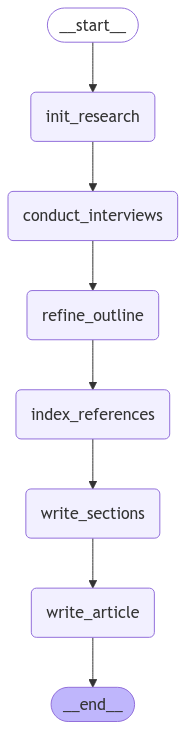

In [ ]:
from IPython.display import Image, display

try:
    display(Image(storm.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"thread_id": "my-thread"}}
async for step in storm.astream(
    {
        # "topic": "熱・風以外の方法で髪の毛を乾かす技術のトレンドを教えて",
        # "topic": "アミンを用いた固体状のCO2吸着剤のトレンドを教えて",
        "topic": "エクソソームの研究のトレンドを教えて",
        # "topic": "安全に関する行動変容手法のトレンドを教えて",
        # "topic": "加熱調理器における料理品質・体験・機能に関する開発のトレンドを教えて",
    },
    config,
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])

init_research
--  {'topic': 'エクソソームの研究のトレンドを教えて', 'outline': Outline(page_title='エクソソームの研究トレンド', sections=[Section(section_title='概要', description='エクソソームは細胞から分泌される小胞（30〜150 nm程の粒子）であり、細胞間コミュニケーションに重要な役割を果たすとされる。特に様々なタンパク質、脂質、核酸などを含むため、診断・治療の両面で新たな可能性が期待されている。近年その機能解明が進むにつれ、研究分野は急速に拡大しており、がん、生殖免疫、神経科学、幹細胞治療など多岐にわたる分野


<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))
<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))
<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  message = HumanMessage(**message.dict(exclude={"type"}))
<ipython-input-14-4447ab4b0c39>:32: PydanticDeprecatedSince20: The 

conduct_interviews
--  {'topic': 'エクソソームの研究のトレンドを教えて', 'outline': Outline(page_title='エクソソームの研究トレンド', sections=[Section(section_title='概要', description='エクソソームは細胞から分泌される小胞（30〜150 nm程の粒子）であり、細胞間コミュニケーションに重要な役割を果たすとされる。特に様々なタンパク質、脂質、核酸などを含むため、診断・治療の両面で新たな可能性が期待されている。近年その機能解明が進むにつれ、研究分野は急速に拡大しており、がん、生殖免疫、神経科学、幹細胞治療など多岐にわたる分野
refine_outline
--  {'topic': 'エクソソームの研究のトレンドを教えて', 'outline': Outline(page_title='エクソソームの研究トレンド', sections=[Section(section_title='概要', description='エクソソーム（exosome）は、細胞が分泌する直径30〜150 nm程度の細胞外小胞の一種であり、タンパク質・脂質・核酸など多様な分子を含むことから、細胞間コミュニケーションや疾患の進行・制御に重要な役割を果たすと考えられている。近年はがん、免疫疾患、精神神経疾患など多岐にわたる領域で応用研究が急速に進展しており、診断・治療の両面で高い
index_references
--  {'topic': 'エクソソームの研究のトレンドを教えて', 'outline': Outline(page_title='エクソソームの研究トレンド', sections=[Section(section_title='概要', description='エクソソーム（exosome）は、細胞が分泌する直径30〜150 nm程度の細胞外小胞の一種であり、タンパク質・脂質・核酸など多様な分子を含むことから、細胞間コミュニケーションや疾患の進行・制御に重要な役割を果たすと考えられている。近年はがん、免疫疾患、精神神経疾患など多岐にわたる領域で応用研究が急速に進展しており、診断・治療の両面で高い
write_sections
--  {'topic': 'エクソソ

In [ ]:
checkpoint = storm.get_state(config)
article = checkpoint.values["article"]

## Render the Wiki

Now we can render the final wiki page!

In [ ]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))

# エクソソーム

### 概要
エクソソームは細胞が放出する直径30～150nm程度の膜小胞で、タンパク質・脂質・核酸など多様な生体分子を内包している[2][3]。もともとは不要物質の排出経路とみなされていたが、1990年代以降、細胞間情報伝達における重要な役割が明らかとなり、研究が急速に進展した[2][4]。近年では、がん、再生医療、神経変性疾患など幅広い領域で注目されており、特にバイオマーカーやドラッグデリバリーシステム（DDS）としての応用研究が活発化している[3][4]。エクソソームは血液や尿など多数の体液中から検出可能であり、がんや感染症などの病態把握や診断、治療効果モニタリングに活用できる潜在性を有すると期待される一方、その分離や特性解析を標準化する研究課題も残されている[2][4][1]。

### エクソソーム研究の変遷
エクソソームが細胞間コミュニケーションに重要な役割を担うことが徐々に認識されるようになった背景には、1980年代から続く研究の積み重ねと技術革新がある。初期には細胞老廃物の排出経路と捉えられていたが、多様な生理機能と病理学的意義が次第に明らかとなり、がんや免疫、神経変性疾患など幅広い分野で注目を集めることとなった。

#### 研究黎明期（1980年代〜1990年代）
1980年代に、赤血球などから放出される細胞外小胞としてエクソソームが初めて報告された際には、不要なタンパク質を排出するメカニズムとして注目されていた[2]。しかし、1990年代に入り、複数の細胞がエクソソームを分泌し、分泌先の細胞との間で分子情報をやり取りする可能性が示唆されるようになった。この時期にはまだエクソソーム研究の規模は限定的であったが、培養細胞系から得られるエクソソームの機能解析や分離技術の確立が徐々に進められていった。

#### 技術革新と応用拡大（2000年代〜）
2000年代に入ると、次世代シーケンサーをはじめとするオミクス解析技術が発達し、エクソソーム内に含まれるRNAやタンパク質のプロファイルを高精度で解析できるようになった[2][3]。同時に、超遠心法やサイズ排除クロマトグラフィー、イムノアフィニティ法などの高度な分離・精製技術が普及し、より高純度のエクソソームを安定的に取得することが可能となった。当初は基礎研究の領域にとどまっていたエクソソーム研究は、がんの診断や治療標的としてのポテンシャルが見出されるにつれ急速に注目度が高まった[4]。さらに、免疫学的応答や幹細胞を用いた再生医療への応用など、多方面での利用が模索されている。こうした流れの中、特許出願や企業による研究開発も増加し、国際的な学術雑誌への論文投稿数も右肩上がりに増加している[3]。

### 主要な研究トピック
エクソソーム研究は、さまざまな疾患領域や生理機能にわたって急速に拡大している。がん微小環境における機能解明やドラッグデリバリーシステムとしての利用可能性、免疫応答や炎症制御における役割など、複合的要素を含む研究が数多く行われている。また、神経変性疾患や再生医療など幅広い分野に適用しうる知見が得られていることから、診断・治療両面での新規技術開発に向けた研究がさらに加速している。

#### がん微小環境と転移研究
がん細胞が分泌するエクソソームは、転移先の微小環境を整える“プログラミング”機能を持つと考えられており、免疫細胞や間質細胞といったさまざまな標的細胞に情報を伝達することで腫瘍細胞の生存や定着を促進する[4][5]。また、エクソソームはがんの増殖能や薬剤耐性の獲得にも関与しているため、がん治療標的としての重要性が注目されている。

#### 免疫調整と自己免疫疾患
エクソソームは抗原提示やサイトカイン分泌などの免疫反応に関与し、免疫細胞間の情報交換を仲介する役割を担う[3]。自己免疫疾患においても、エクソソームが炎症の制御や免疫寛容の破綻に関与する可能性が示唆されており、病態解明と新規治療法開発に向けた研究が行われている。

#### 神経変性疾患への応用
アルツハイマー病やパーキンソン病などの神経変性疾患において、エクソソームを介したmisfoldedタンパク質の拡散や神経保護効果の発現などが検討されている。エクソソーム内に含まれる特定のタンパク質や核酸が病態形成、あるいは修復プロセスに関与し得ることが示唆され、バイオマーカー探索と治療応用双方の面で注目されている[4][5]。

#### 再生医療と組織修復
幹細胞由来エクソソームは、組織修復や再生を促す活性を持つことが報告されており、細胞移植を伴わない再生医療技術として期待が寄せられている。心疾患や骨・軟骨障害など多領域の臨床応用を目指して研究開発が進行している。

#### バイオマーカー探索
血液や体液中を流れるエクソソームには疾患特異的なmiRNAやタンパク質が含まれるため、非侵襲的な検体採取でより早期に疾患を発見・モニタリングする手法として期待を集めている[2][4]。特にがん領域においては、血中のエクソソームを解析するリキッドバイオプシーによる早期診断技術の開発が活発化している。

#### ドラッグデリバリーシステム（DDS）
生体由来のエクソソームは免疫原性の低さや細胞特異的な取り込みを強化できる利点があり、薬剤や遺伝子を搭載したDDSキャリアとして注目を浴びている[2]。特定の受容体に対するリガンドを表面に導入する技術が進展しており、がんや難治性疾患への標的型治療の実用化も期待されている。

#### 標準化と改変技術
分離法や純度評価、物性解析の標準化は未だ確立途上であり、エクソソーム研究の進展には大量生産技術や品質管理体制の確立が欠かせない。さらに、エクソソームの膜タンパク質や内部cargoを人工的に改変する技術が進行しており、精密医療や先端治療への応用を見据えた研究が加速している[3][4]。

### 最新の技術動向
エクソソーム研究の進展は、高感度・高速な分離・検出技術や大容量データ解析手法の普及により大きく加速している。近年は、高度なマススペクトロメトリーを利用したプロテーム解析や、高精度の次世代シーケンサーを用いた核酸解析がさらに洗練され、エクソソーム内包分子の包括的なカタログ化が進行している[2][3]。また、がんや感染症など多様な疾患由来のエクソソームを効率的に検出・定量するために、マイクロ流体工学や電気化学的バイオセンサー、プラズモン共鳴センサーといった様々な計測技術の開発が活発化している[3][5]。加えて、エクソソームの表面修飾技術やナノ粒子とのハイブリッド化など、新しいエンジニアリング手法の研究も進み、DDSや診断ツールとしての応用可能性が一層広がっている[4]。

#### 先進的な検出・分離技術の開発
エクソソームを高純度で分離し、かつ疾患ごとの特徴を検出するために、免疫アッセイやサイズ排除クロマトグラフィー、マイクロ流体デバイスを組み合わせたハイブリッド手法が提案されている[3]。試料中のエクソソームを直接捕捉・定量するラベルフリーセンサーの研究も進んでおり、非侵襲的な診断への応用が期待される。さらに、一度に複数の生体分子を測定可能な高感度プラットフォームやナノテクノロジーを取り入れた新しいデバイスの開発により、エクソソーム解析の高速化と高精度化が実現しつつある。

#### エクソソームの改変技術と応用
エクソソームの機能を強化・改変する研究として、表面に特異的なリガンドやペプチドを付与し、標的細胞・組織への選択的な送達を可能にする手法が模索されている[4]。加えて、ゲノム編集技術や核酸結合分子の導入によって、内部に特定の遺伝子や医薬品を封入しやすくするアプローチも検討が進む。これらの先端技術と製造プロセスの最適化により、標準化されたエクソソーム製剤の実用化が見込まれている。

### 安全性評価と規制課題
エクソソームを医療用途やバイオ産業で活用するにあたっては、安全性や有効性だけでなく、製造プロセスや品質管理の標準化、規制対応など多岐にわたる課題の解消が不可欠とされる。特に、細胞由来製剤としてのエクソソームはその生物学的特性や微量成分の変動要因が多岐にわたるため、厳格な評価体制と法的枠組みの構築が求められている。さらに、近年では企業やクリニックによるエクソソーム・細胞外小胞製品の直接販売が増加しており、安全性や治療効果に対する信頼性を確保するための監視や基準整備が課題として浮上している[2][3]。

#### 品質管理と製造基準の確立
エクソソーム製剤を臨床現場へ導入するには、生産過程での精製度や活性の再現性を担保するための標準化が不可欠となる。具体的には、使用細胞の種類や培養条件、分離・精製方法の効率や再現性を一定に保ちつつ、エクソソームに内包されるタンパク質や核酸などのバイオアクティブ因子の均質化を図る必要がある[2]。さらに、製造後の性状を定量的に評価するための品質試験項目を定義し、規制当局が要求する基準を満たす形で製品化することが望ましい。こうした取り組みにより、エクソソームの臨床応用を進める際の安全性と有効性を証明する土台が整備されていく。

#### 未承認製品と直接販売のリスク
幹細胞やエクソソームを利用した再生医療技術への関心が高まるにつれ、企業やクリニックが未承認のエクソソーム製品を直接販売するケースが散見される[3]。これらの製品は厳密な安全性評価や有効性データに基づく承認を経ていない場合が多く、患者にとって健康リスクや経済的リスクが懸念される。特に美容や抗加齢領域では、科学的根拠や適切な使用法が確立されていないまま治療として提供される例も報告されており、国際的な規制やガイドラインの整備が急務とされる。

#### 国際的枠組みと標準化の動向
エクソソーム基盤研究の発展に伴い、国際的には研究者コミュニティや学会を中心に、製造・品質管理プロセスや安全管理指針を整備する動きが活発化している。たとえば国際細胞外小胞学会（ISEV）や欧州のCOSTプログラムでは、エクソソームを含む細胞外小胞の治療応用に関する品質保証やリスク評価、法規制上の位置づけに関する議論が進められている[2][5]。これらの取り組みは、企業接続型の研究だけでなく、公的機関が主導する大規模臨床試験やガイドライン策定の基礎にもなっており、今後さらに広がる見通しである。

### 課題と展望
エクソソーム研究の展望としては、さらなる基礎解析と標準化された評価法の確立、工業的な大量生産技術の確立、そして多様な疾患領域における新規治療・診断応用の可能性が挙げられる。一方で、他の細胞外小胞やマイクロベジクルなどとの区別や、分離・精製手法の精度向上と国際的なガイドラインの策定には多くの課題が残されている。今後は分子プロファイリングや解析プラットフォームの高度化が進むことで、安全性や有効性を担保しながら、エクソソームを活用したバイオマーカー開発やドラッグデリバリーシステムがより具体的に実用化されると期待される。

#### 標準化と品質管理の課題
エクソソームには多様性が存在し、他の細胞外小胞との厳密な区別が難しい。そのため、分離技術や定義づけに関する標準化が国際的に議論されている[5]。品質管理についても、高純度のエクソソームを継続的に安定供給するためのガイドライン整備が重要であり、様々な研究グループによる再現性ある実験手法の共有が課題となっている。

#### 大量生産と応用研究の可能性
エクソソームを治療応用に用いるには工業的な大量生産体制や品質保証体制の確立が欠かせない[3][4]。免疫原性の低さや細胞特異的な取り込みを促す特性から、DDSやがん治療への応用研究が活発化しているが、規制当局の基準を満たす安全性や均質性をどのように担保するかが大きな課題である。今後はバイオマーカーとしての測定プラットフォームと合わせて、製造プロセスや品質試験方法のさらなる標準化が求められる[2][5]。

#### 今後の展望と研究拡大
分子プロファイリング技術やオミクス解析の進歩に伴い、エクソソーム内の核酸・タンパク質などの新規バイオマーカー候補の発見が相次いで報告されている[4]。将来的には、個別化医療への貢献や創薬プラットフォームとしての確立が期待されており、世界的にも研究者・企業間の連携が進むことで新たな治療戦略が確立される可能性が高い。特に、がんや神経変性疾患などの重篤な疾患分野において、エクソソームを利用した診断や治療が次世代医療の一翼を担うと見込まれる。

---

### 参考文献
[1] https://doi.org/10.1586/epr.09.17  
[2] https://doi.org/10.3390/bios11120518  
[3] https://doi.org/10.1080/20013078.2018.1438720  
[4] https://doi.org/10.1016/j.tibtech.2019.04.008  
[5] https://doi.org/10.1186/s12964-021-00730-1  
[6] https://doi.org/10.3402/jev.v4.30087  
[7] https://doi.org/10.1186/s13287-023-03335-2  
[8] https://doi.org/10.3390/biom14121599  